In [2]:
%load_ext autoreload
%autoreload 2

import sys
import pandas as pd
from matplotlib import pyplot as plt


sys.path.insert(0, "..") 
from src.data import make_dataset
from src.features import build_features
from src.visualization import visualize

pd.set_option("display.precision", 5)
pd.set_option("display.max.columns", None)
pd.options.display.float_format = '{:6.5f}'.format

import seaborn as sns

Bonds

In dit onderzoek is uitgegaan van een beperkte set bonds. Het is nog onduidelijk of de data van verlopen bonds ook zinvol is voor het onderzoek. Een bond is typisch maar kort in portefeuille waardoor we geen lange tijdreeksen hebben van een bepaalde bond. Mogelijk komt de bond wel erg over een met andere bonds die we in het verleden hebben gehad en zegt het koerstverloop van die bonds iets over het koersverloop van de huidige bonds. Mogelijk spelen benchmark bonds hier een rol bij. 

In [3]:
df_bonds = make_dataset.read_pkl('bonds')

2022-01-12 15:15:41.746 | INFO     | src.data.make_dataset:read_pkl:377 - Load preprocessed bonds data


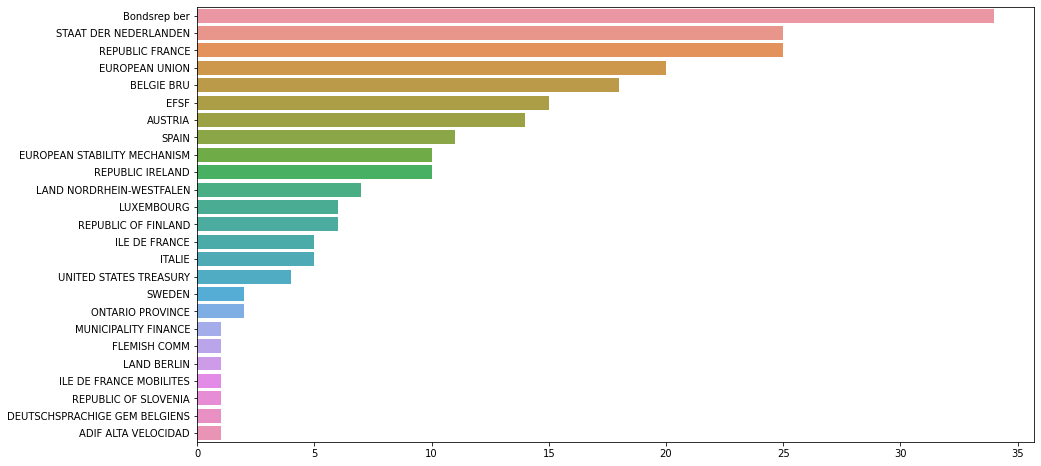

In [4]:
plt.figure(figsize=(15,8))
visualize.countplot(data = df_bonds, x = 'issuer_name')

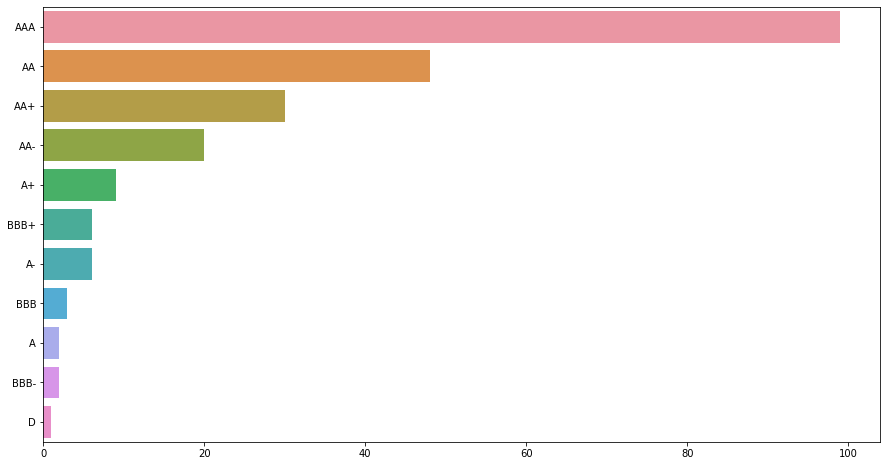

In [5]:
plt.figure(figsize=(15,8))
visualize.countplot(data = df_bonds, x = 'issue_rating')

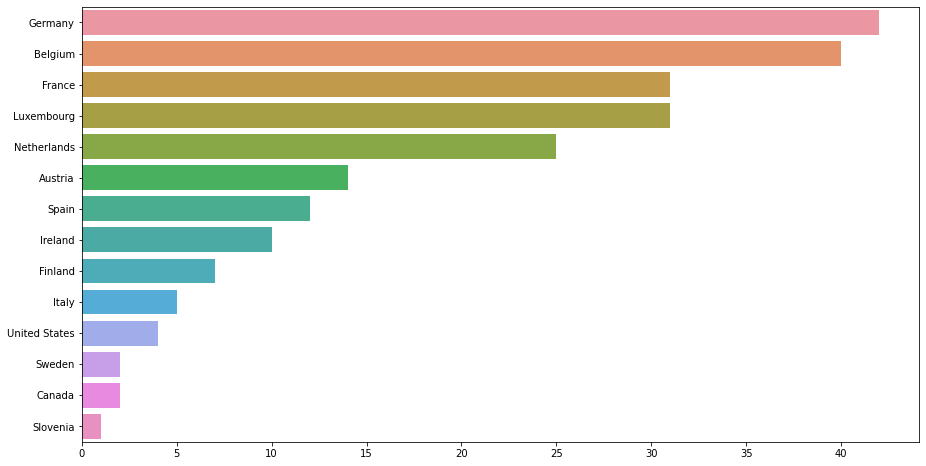

In [6]:
plt.figure(figsize=(15,8))
visualize.countplot(data = df_bonds, x = 'country')

Bond prices

In [7]:
df_price = make_dataset.read_pkl('price')
df_price.head()

2022-01-12 15:15:43.091 | INFO     | src.data.make_dataset:read_pkl:377 - Load preprocessed price data


,reference_identifier,ccy,rate_dt,mid
0,DE0001135143,EUR,2010-12-17,136.76000
1,NL0000102275,EUR,2010-12-17,103.39000
2,DE0001135424,EUR,2010-12-17,95.45300
3,NL0009446418,EUR,2010-12-17,102.69000
4,NL0000102234,EUR,2010-12-17,106.22000


In [8]:
df_price.groupby('reference_identifier').count()


,ccy,rate_dt,mid
reference_identifier,,,
AT0000A001X2,2737,2737,2737
AT0000A0U3T4,2542,2542,2542
AT0000A105W3,2230,2230,2230
AT0000A185T1,1925,1925,1925
AT0000A19XC3,1284,1284,1284
...,...,...,...
XS1062909384,1275,1275,1275
XS1692485912,116,116,116
XS1756338551,1017,1017,1017


2022-01-12 15:15:43.550 | INFO     | src.data.make_dataset:read_pkl:377 - Load preprocessed bp data
2022-01-12 15:15:43.713 | INFO     | src.data.make_dataset:read_pkl:377 - Load preprocessed yield data


<AxesSubplot:xlabel='rate_dt', ylabel='mid'>

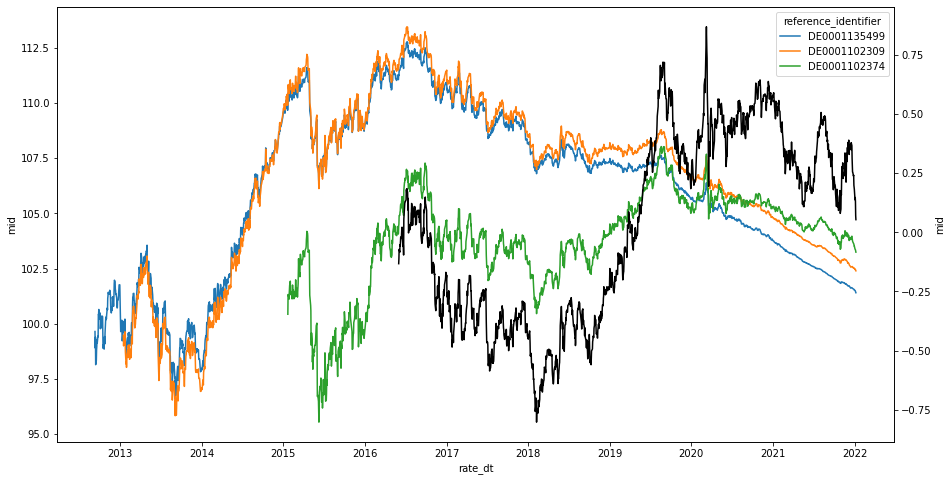

In [9]:
#df = make_dataset.join_bond_data(df_bonds,df_price,['DE0001102309','DE0001102374', 'DE0001135499']) # Example 3 German Bonds 10 Years
plt.figure(figsize=(15,8))

df_bp = make_dataset.read_pkl('bp')

df_yield = make_dataset.read_pkl('yield')
df_y10 = df_yield[df_yield['timeband']=='10 YEARS']
df_y10_germany = df_y10[df_y10['country']=='Germany']


df = df_bp[df_bp['isin'].isin(['DE0001102309','DE0001102374', 'DE0001135499'])]
df = df[df['rate_dt'] >= df_y10_germany['rate_dt'].min()]
sns.lineplot(data = df, x = 'rate_dt', y = 'mid', hue = 'reference_identifier')

df_y10_germany = df_y10_germany[df_y10_germany['rate_dt'] >= df['rate_dt'].min()]
df_y10_germany['mid'] = df_y10_germany['mid'] * -1
ax2 = plt.twinx()
sns.lineplot(data = df_y10_germany, x = 'rate_dt', y = 'mid', color = 'black', ax=ax2)


Wanneer we kijken naar bonds met een zelfde looptijd, en zelfde issuer, dan zien we dat de term spread langzaam afneemt. Ook zien we dat hier waarschijnlijk een fout zit in de invoer

<AxesSubplot:xlabel='rate_dt', ylabel='mid'>

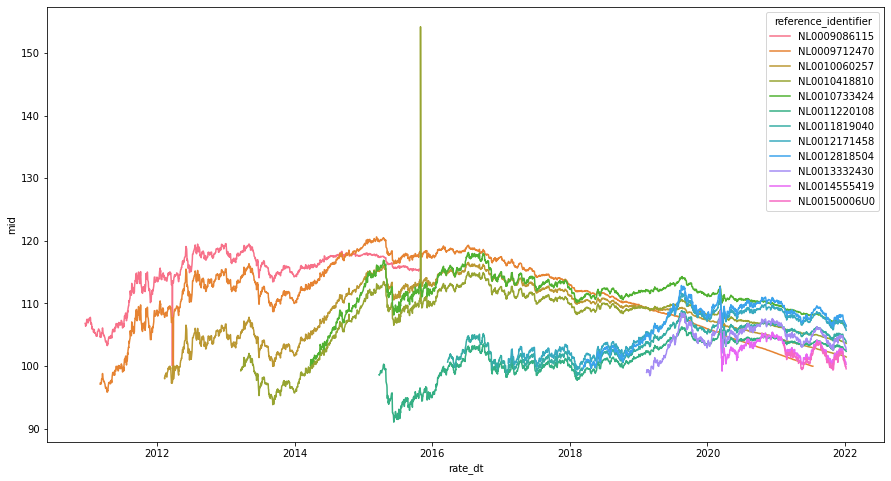

In [10]:
# 10 years bonds from one issuer
df_10y = df_bp[df_bp['bond_duration'].dt.days.between(3500,4000)]
df = df_10y.query('issuer_name == "STAAT DER NEDERLANDEN"').sort_values('first_coupon_date')
plt.figure(figsize=(15,8))
sns.lineplot(data = df, x = 'rate_dt', y = 'mid', hue = 'reference_identifier')

Wanneer we kijken naar bonds met een zelfde looptijd, van verschillende issuers dan zien we het verloop van de credit spread tussen de landen.

<AxesSubplot:xlabel='rate_dt', ylabel='mid'>

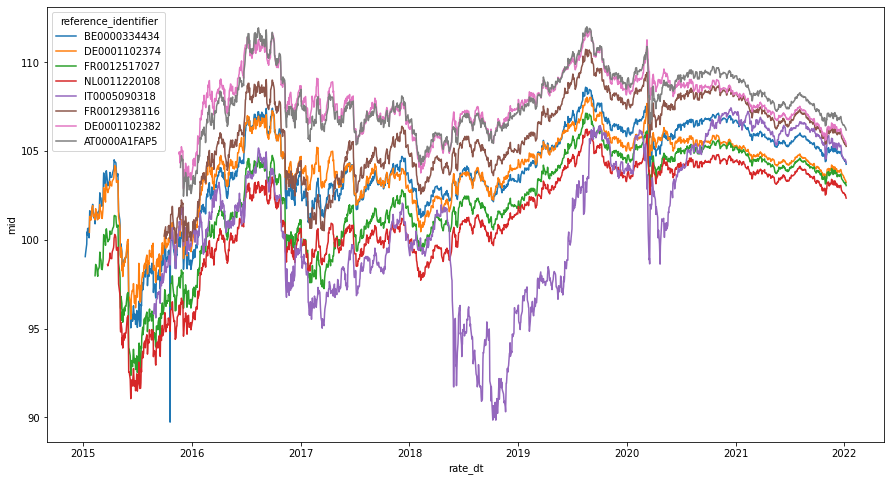

In [11]:
# 10 years bonds from one year

df_10y = df_bp[df_bp['bond_duration'].dt.days.between(3500,4000)]
df  = df_10y[df_10y['issue_dt'].between('1-jan-2015', '31-dec-2015')]
plt.figure(figsize=(15,8))
sns.lineplot(data = df, x = 'rate_dt', y = 'mid', hue = 'reference_identifier')

In [12]:
df_bonds_i = df_bonds[( df_bonds['country'] == 'Italy' ) & (df_bonds['issue_dt'] <= '1-jan-2018')  & (df_bonds['mature_dt'] >= '1-jan-2022')]
df_bonds_i

,ccy,country,issue_dt,first_coupon_date,mature_dt,isin,issuer_name,coupon_frq,coupon,tot_issue,cfi_code,issue_rating,bond_duration
24,EUR,Italy,2015-03-02,2015-06-01,2025-06-01,IT0005090318,ITALIE,SEMI ANNUAL,1.50000,19786.72000,DBFUFB,BBB-,3744 days
84,EUR,Italy,2016-03-01,2016-06-01,2026-06-01,IT0005170839,ITALIE,SEMI ANNUAL,1.60000,16249.50000,DBFUFB,BBB-,3744 days


<AxesSubplot:xlabel='rate_dt', ylabel='mid'>

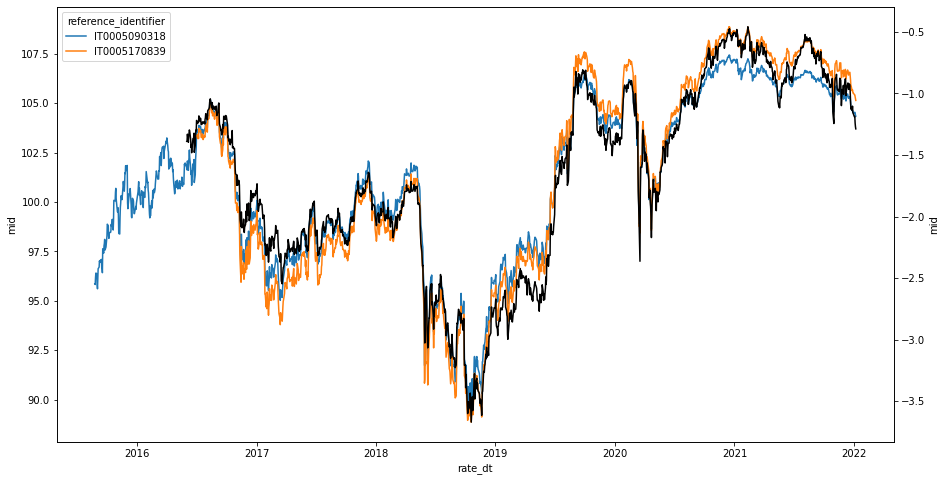

In [13]:
isins = df_bonds_i['isin'].to_list()
df_bp_i = df_bp[df_bp['isin'].isin(isins)]
plt.figure(figsize=(15,8))
sns.lineplot(data = df_bp_i, x = 'rate_dt', y = 'mid', hue = 'reference_identifier')

df_y10_italy = df_y10[df_y10['country']=='Italy']
df_y10_italy = df_y10_italy[df_y10_italy['rate_dt'] >= df_bp_i['rate_dt'].min()]
df_y10_italy['mid'] = df_y10_italy['mid'] * -1
ax2 = plt.twinx()
sns.lineplot(data = df_y10_italy, x = 'rate_dt', y = 'mid', color = 'black', ax=ax2)

# Yield Curve

De yield curve wordt samengesteld door de prijzen van government bonds te vergelijken en te projecteren. Een van de features die vanuit de literatuur wordt aangedragen is de 'term spread'. Dit is het verschil tussen korte en lange rente. We zien in onderstaand plaatje dat het verschil in korte en langer rente tot 2019 terug liep.


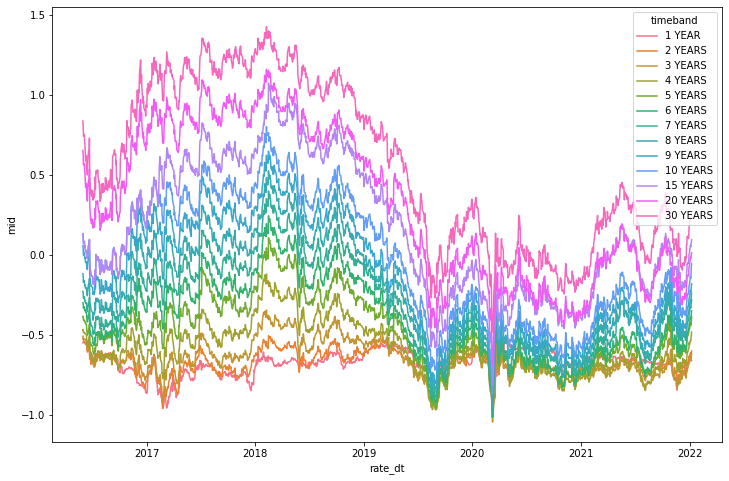

In [17]:
df_yield = make_dataset.read_pkl('yield')
df_yield = df_yield[df_yield['rate_dt'] > '1-jan-2010']

country = 'Germany'
df_country = df_yield[df_yield['country']==country]

plt.figure(figsize=(12, 8))
hue_order = sorted(df_country['timeband'].unique(), key = lambda x: int(x[0:2]))
ax = sns.lineplot(data = df_country, x = 'rate_dt', y = 'mid', hue = 'timeband', hue_order=hue_order)

Credit Spread

Inflation

De rente is theoretisch gecorreleerd aan de inflatie verwachting. In de praktijk is deze correlatie niet altijd evident. Ook is het niet duidelijk of de bondprijzen worden gevormd door de lnflatieverwachting, of omgekeerd de inflatie wordt afgeleid uit stijgende prijzen voor staatsobligaties.

In [27]:
df_inflation['country'].unique()

<StringArray>
['Germany', 'France', 'Spain', 'Italy', 'United States']
Length: 5, dtype: string

2022-01-12 15:25:21.619 | INFO     | src.data.make_dataset:read_pkl:377 - Load preprocessed inflation data


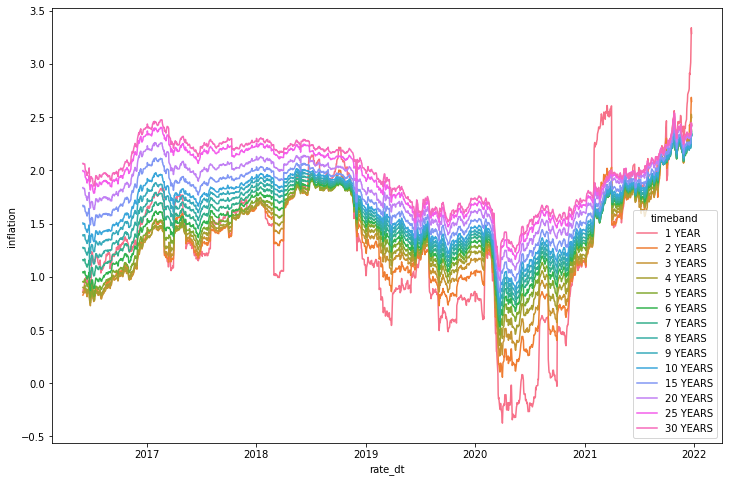

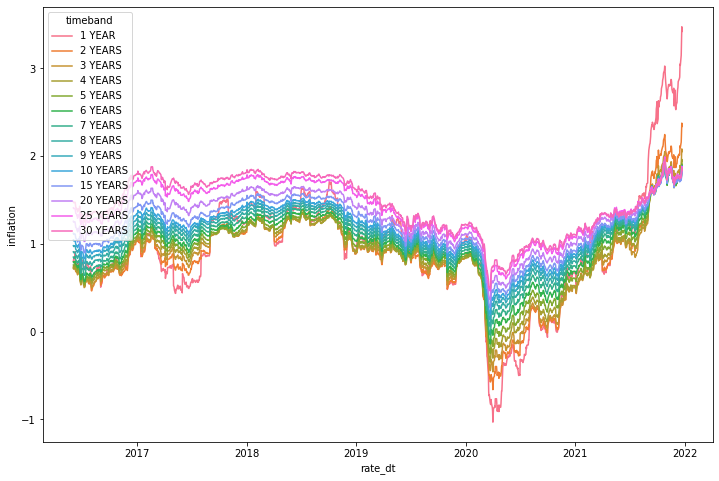

In [29]:

df_inflation = make_dataset.read_pkl('inflation')
df_inflation = df_inflation[df_inflation['rate_dt'] > df_yield['rate_dt'].min()]

country = 'Germany'
df_country = df_inflation[df_inflation['country']==country]

plt.figure(figsize=(12, 8))
hue_order = sorted(df_country['timeband'].unique(), key = lambda x: int(x[0:2]))
ax = sns.lineplot(data = df_country, x = 'rate_dt', y = 'inflation', hue = 'timeband', hue_order=hue_order)

country = 'Italy'
df_country = df_inflation[df_inflation['country']==country]

plt.figure(figsize=(12, 8))
hue_order = sorted(df_country['timeband'].unique(), key = lambda x: int(x[0:2]))
ax = sns.lineplot(data = df_country, x = 'rate_dt', y = 'inflation', hue = 'timeband', hue_order=hue_order)

Inflation should be negatively correlated to the bond price